In [1]:
using Gen
using Distributions
using Random
using Plots

In [2]:
@gen function seir_model(T::Int, N::Int)
    # Latent parameters with priors
    beta_var ~ beta(2, 3)    # transmission probability
    sigma_var ~ beta(2, 5)   # incubation rate
    gamma_var ~ beta(2, 8)   # recovery rate

    # Initial states
    S = N - 1
    E = 0
    I = 1
    R = 0

    infected_counts = Int[]

    for t in 1:T
        # Probabilities
        infection_prob  = min(beta_var * I / N, 1.0)
        incubation_prob = sigma_var
        recovery_prob   = gamma_var

        # Transitions using Binomial counts
        new_E = @trace(binom(S, infection_prob), (:new_E, t))
        new_I = @trace(binom(E, incubation_prob), (:new_I, t))
        new_R = @trace(binom(I, recovery_prob), (:new_R, t))

        # Update compartments
        S -= new_E
        E += new_E - new_I
        I += new_I - new_R
        R += new_R

        # Observation tied to infectious individuals
        obs = @trace(poisson(I), (:obs, t))
        push!(infected_counts, obs)

        @assert S + E + I + R == N  # sanity check
    end

    return infected_counts
end


DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing], Main.var"##seir_model#277", Bool[0, 0], false)

In [3]:
Random.seed!(4)

T = 100
N = 100

(trace, _) = generate(seir_model, (T, N))


println("Observations:")
println(get_retval(trace))

println("\nLatent parameters:")
println("β = ", trace[:beta_var])
println("σ = ", trace[:sigma_var])
println("γ = ", trace[:gamma_var])

Observations:
[1, 1, 0, 1, 2, 4, 4, 15, 12, 15, 18, 25, 21, 25, 30, 38, 38, 71, 80, 64, 42, 63, 68, 58, 58, 41, 58, 66, 60, 52, 40, 38, 55, 38, 45, 38, 32, 33, 46, 37, 28, 29, 31, 33, 31, 24, 26, 25, 18, 19, 22, 10, 16, 16, 8, 12, 10, 7, 6, 9, 9, 3, 9, 4, 10, 4, 3, 3, 3, 5, 3, 4, 1, 1, 0, 4, 3, 3, 2, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0]

Latent parameters:
β = 0.8358484962604672
σ = 0.2519623991527895
γ = 0.048477374048150904


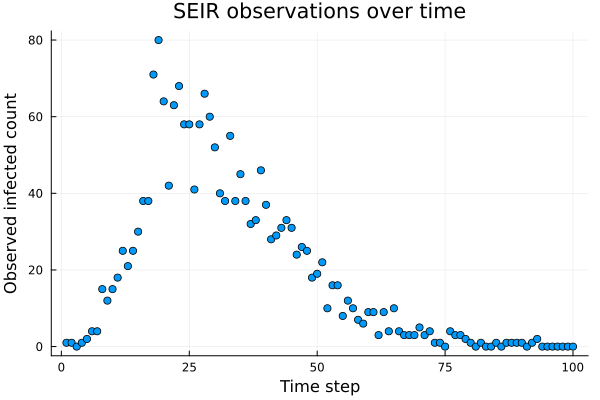

In [4]:
obs = get_retval(trace)

scatter(
    1:length(obs),
    obs,
    xlabel = "Time step",
    ylabel = "Observed infected count",
    title = "SEIR observations over time",
    legend = false
)
